# Ocular Disease Prediction Model

### Step 1: Import libraries

In [24]:
import os, glob, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.model_selection import train_test_split

### Step 2: Read dataset

In [10]:
data = pd.read_csv("./data/full_df.csv")
data.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


### Step 3: Extract information

In [16]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
  
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
  
    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values
     
    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values

    normalones = np.concatenate((left_normal,right_normal),axis = 0)
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0)
    diabones = np.concatenate((left_diab,right_diab),axis = 0)
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0)
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0)
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0)
    age = np.concatenate((left_age,right_age),axis=0)
    other = np.concatenate((left_other,right_other),axis = 0)
    
    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other

In [17]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data)

print("Dataset stats")
print("Normal:" , len(normal))
print("Cataract:" , len(cataract))
print("Diabetes:" , len(diab))
print("Glaucoma:" , len(glaucoma))
print("Hypertension:" , len(hyper))
print("Myopia:" , len(myopia))
print("Age Issues:" , len(age))
print("Other:" , len(other))

Dataset stats
Normal: 700
Cataract: 594
Diabetes: 1818
Glaucoma: 610
Hypertension: 374
Myopia: 479
Age Issues: 551
Other: 324


In [21]:
dataset_dir = "C:/Users/rocky/OneDrive/Desktop/URO/dataset/archive/preprocessed_images"
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir,img)
        
        #now we try to read the image and resize it accordingly
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    
    return dataset

In [22]:
dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

len(dataset)

100%|██████████| 324/324 [00:04<00:00, 68.76it/s] 


5396

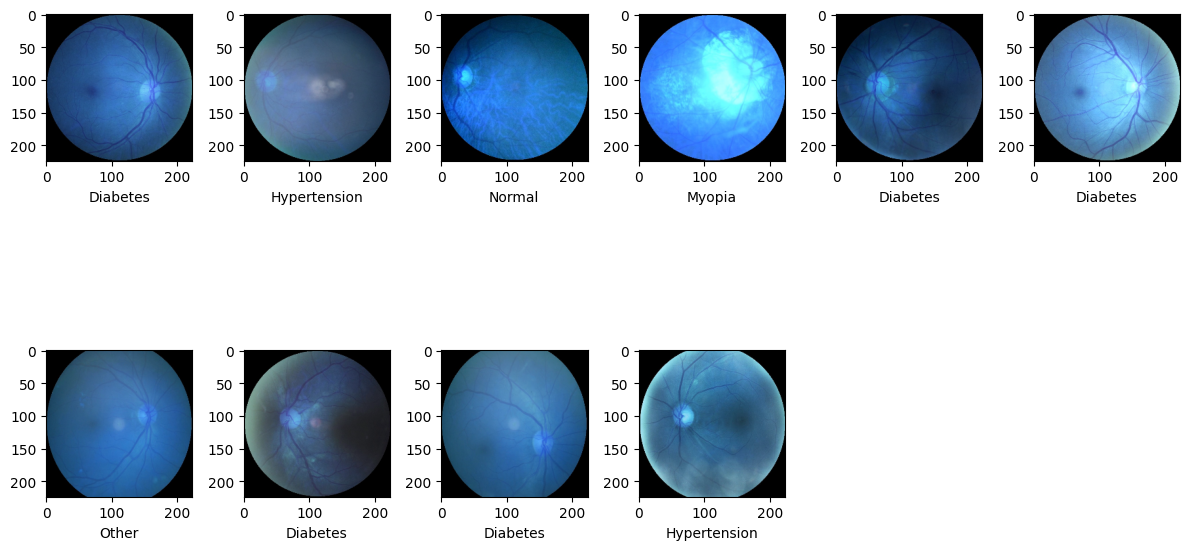

In [23]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
           
    plt.subplot(2,6,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

### Step 4: Split training and testing sets

In [25]:
train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])

x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)

y_train_cat = to_categorical(y_train,num_classes=8)
y_test_cat = to_categorical(y_test,num_classes=8)

### Step 5: Create the model

In [26]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

In [27]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(8,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       